In [ ]:
!pip install -q tensorflow-probability==0.18.0

In [1]:
from keras.datasets import cifar10
from keras.applications import ResNet50
from keras import layers, Input, Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.metrics import Mean, MAE
from keras.models import load_model
from keras.losses import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import glob

Vector quantizer is the layer in between the encoder and decoder

Vector quantizer will flatten the output from the encoder (batch, height, width, filters) to (batch * height * width, filters) to treat the total number of filters as the size for the latent embeddings.

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        # Initialize the embeddings to quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [3]:
def get_encoder(latent_dim=16):
    encoder_inputs = Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return Model(latent_inputs, decoder_outputs, name="decoder")

In [4]:
def get_vqvae(shape, latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = Input(shape=shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")


get_vqvae(shape=(28, 28, 1)).summary()

Metal device set to: Apple M1 Pro


2023-01-26 11:26:14.788260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-26 11:26:14.788401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [5]:
class VQVAETrainer(Model):
    def __init__(self, data_shape, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(shape=data_shape, latent_dim=self.latent_dim, num_embeddings=self.num_embeddings)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

Train VQVAE neural network

In [7]:
# vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=32, num_embeddings=256)
vqvae_trainer.compile(optimizer=Adam())

history = vqvae_trainer.fit(x_train_scaled,
                            epochs=50,
                            batch_size=128)

Epoch 1/50


2023-01-26 11:26:55.487194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-26 11:26:55.710294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 10s 20ms/step - loss: 2.6679 - reconstruction_loss: 0.3481 - vqvae_loss: 2.0057
Epoch 2/50
469/469 [==============================] - 9s 19ms/step - loss: 2.9955 - reconstruction_loss: 0.1603 - vqvae_loss: 2.8236
Epoch 3/50
469/469 [==============================] - 9s 19ms/step - loss: 1.2483 - reconstruction_loss: 0.1260 - vqvae_loss: 1.1148
Epoch 4/50
469/469 [==============================] - 9s 19ms/step - loss: 0.7289 - reconstruction_loss: 0.1083 - vqvae_loss: 0.6174
Epoch 5/50
469/469 [==============================] - 9s 19ms/step - loss: 0.5463 - reconstruction_loss: 0.0944 - vqvae_loss: 0.4485
Epoch 6/50
469/469 [==============================] - 9s 19ms/step - loss: 0.4190 - reconstruction_loss: 0.0836 - vqvae_loss: 0.3333
Epoch 7/50
469/469 [==============================] - 9s 19ms/step - loss: 0.3701 - reconstruction_loss: 0.0762 - vqvae_loss: 0.2920
Epoch 8/50
469/469 [==============================] - 9s 19ms/step - loss: 0.33

Loss

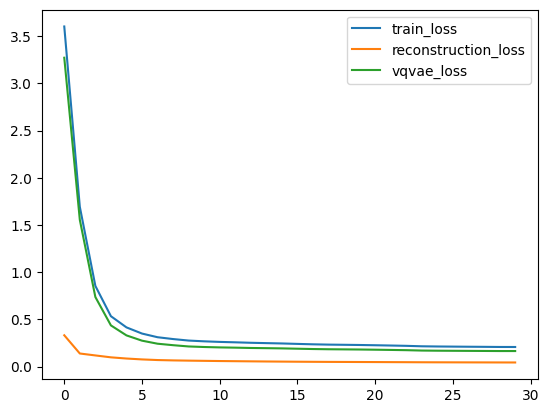

In [14]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'reconstruction_loss': history.history["reconstruction_loss"],
    'vqvae_loss': history.history["vqvae_loss"]}).plot();

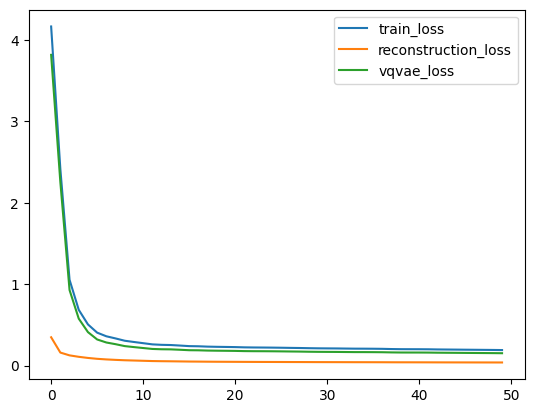

In [8]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'reconstruction_loss': history.history["reconstruction_loss"],
    'vqvae_loss': history.history["vqvae_loss"]}).plot();

In [15]:
# del vqvae_trainer

# Training Pixel Model

In [14]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
decoder = vqvae_trainer.vqvae.get_layer('decoder')

In [15]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 2s 1ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


In [16]:
num_residual_blocks = 3
num_pixelcnn_layers = 3
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


In [17]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

In [19]:
filters = vqvae_trainer.num_embeddings

pixelcnn_inputs = Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=filters, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=filters)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=filters,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 256)         0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 7, 7, 256)        3211520   
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 7, 7, 256)        393856    
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 7, 7, 256)        393856    
 lock)                                                           
                                                         

In [20]:
pixel_cnn.compile(
    optimizer=Adam(3e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=50,
    validation_split=0.1,
)

Epoch 1/50


2023-01-26 11:37:18.097218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 1.7997 - accuracy: 0.6105

2023-01-26 11:37:47.375812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 31s 72ms/step - loss: 1.7997 - accuracy: 0.6105 - val_loss: 1.3200 - val_accuracy: 0.6378
Epoch 2/50
422/422 [==============================] - 30s 71ms/step - loss: 1.2288 - accuracy: 0.6527 - val_loss: 1.1848 - val_accuracy: 0.6588
Epoch 3/50
422/422 [==============================] - 30s 71ms/step - loss: 1.1471 - accuracy: 0.6660 - val_loss: 1.1427 - val_accuracy: 0.6667
Epoch 4/50
422/422 [==============================] - 30s 71ms/step - loss: 1.1058 - accuracy: 0.6736 - val_loss: 1.1205 - val_accuracy: 0.6706
Epoch 5/50
422/422 [==============================] - 30s 71ms/step - loss: 1.0781 - accuracy: 0.6793 - val_loss: 1.1135 - val_accuracy: 0.6714
Epoch 6/50
422/422 [==============================] - 30s 71ms/step - loss: 1.0575 - accuracy: 0.6837 - val_loss: 1.1150 - val_accuracy: 0.6697
Epoch 7/50
422/422 [==============================] - 30s 71ms/step - loss: 1.0402 - accuracy: 0.6876 - val_loss: 1.1037 - val_accuracy: 0.6730
Epo

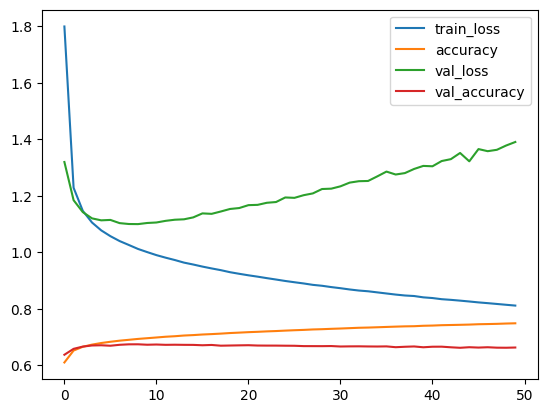

In [21]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'accuracy': history.history["accuracy"],
    'val_loss': history.history["val_loss"],
    'val_accuracy': history.history["val_accuracy"]}).plot();

In [22]:
# del pixel_cnn

In [23]:
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = Model(inputs, outputs)

## Inference with test data

In [24]:
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

1/1 [==============================] - 0s 13ms/step


In [25]:
batch, rows, cols = codebook_indices.shape
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

2023-01-26 13:16:00.385028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step
Prior shape: (10, 7, 7)


## Inference with unknown data

In [62]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 16ms/step


2023-01-26 10:51:26.968869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step
Prior shape: (10, 7, 7)


1/1 [==============================] - 0s 12ms/step


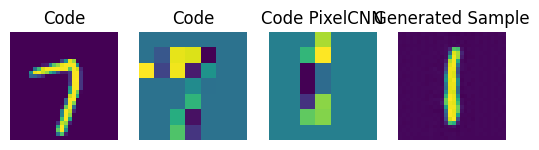

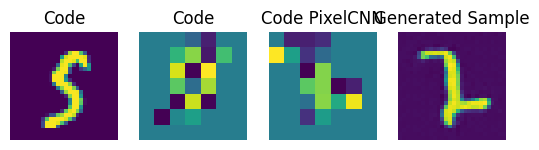

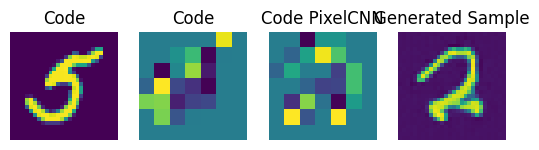

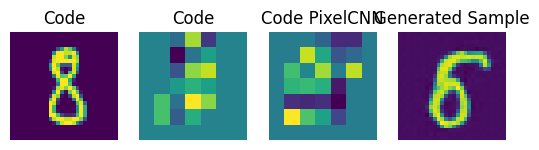

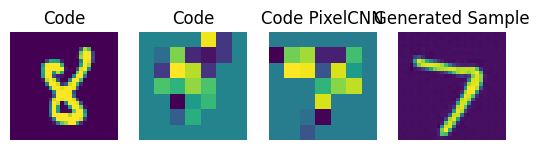

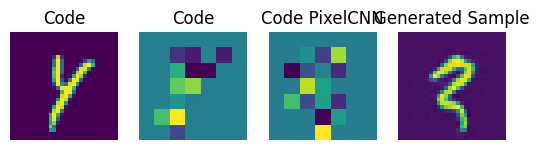

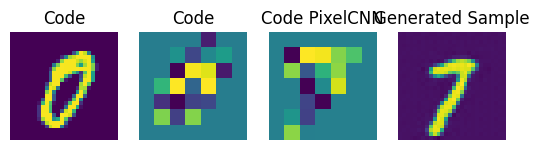

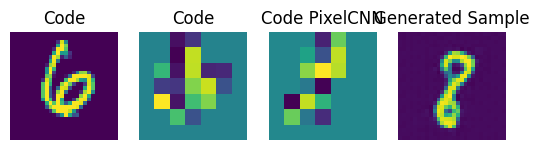

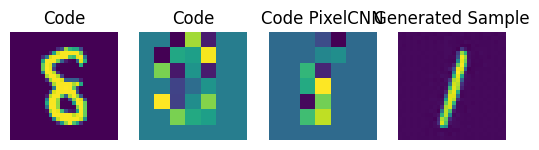

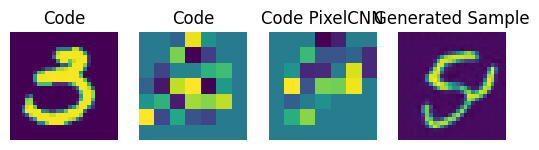

In [27]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 4, 1)
    plt.imshow(test_images[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(priors[i])
    plt.title("Code PixelCNN")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

# Visualize Origin vs Quantized vs Reconstructed with test data

In [28]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
decoder = vqvae_trainer.vqvae.get_layer('decoder')

In [29]:
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

1/1 [==============================] - 0s 11ms/step


In [30]:
quantized_latents = quantizer(encoded_outputs)
reconstructed_img = decoder.predict(quantized_latents)

1/1 [==============================] - 0s 10ms/step


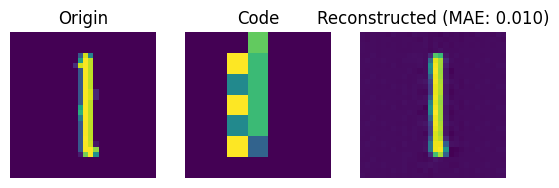

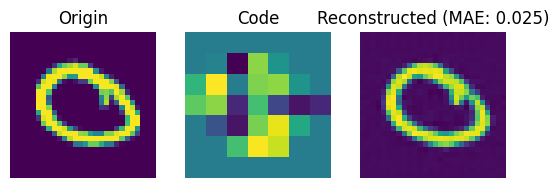

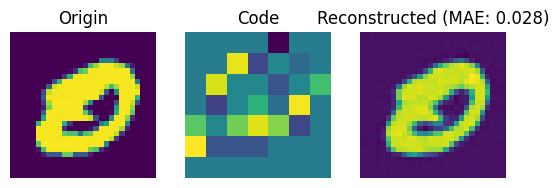

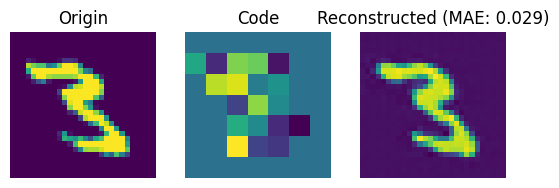

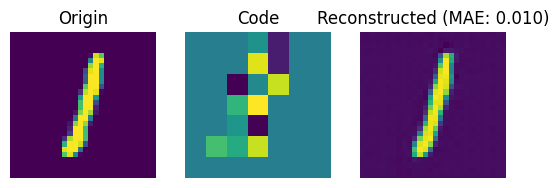

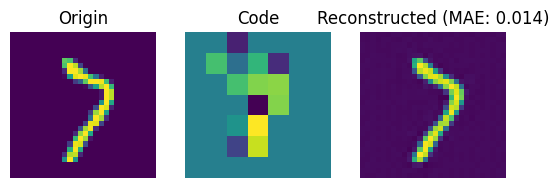

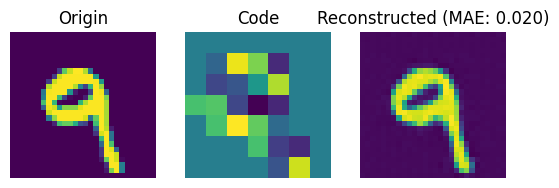

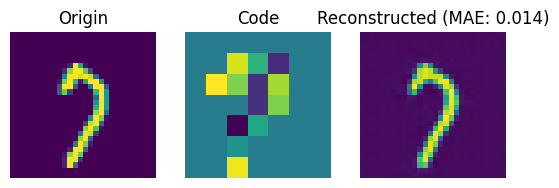

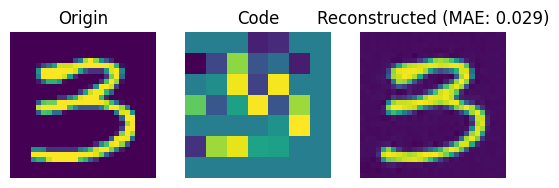

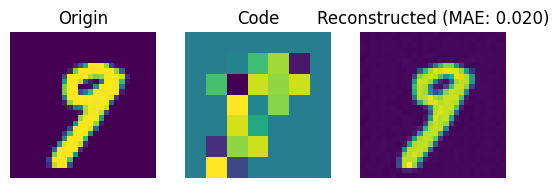

In [31]:
for i in range(len(test_images)):
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title("Origin")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")

    mean_absolute_error = MAE(test_images[i].flatten(), reconstructed_img[i].flatten())
    mean_absolute_error = np.round(mean_absolute_error.numpy(), 3)

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_img[i])
    plt.title(f"Reconstructed (MAE: {f'{mean_absolute_error}'[:5]})")
    plt.axis("off")
    plt.show()

In [51]:
# version = glob.glob('../models/*').__len__() + 1
#
# file_path = f'../models/lossless_compressor_model_v{version}'
# vqvae_trainer.vqvae.save(file_path)

INFO:tensorflow:Assets written to: ../models/lossless_compressor_model_v1/assets


INFO:tensorflow:Assets written to: ../models/lossless_compressor_model_v1/assets


In [52]:
# loaded_model = load_model(file_path)

In [131]:
# decoder.save(f'../models/lossless_compressor_decoder_v{version}')

INFO:tensorflow:Assets written to: ../models/lossless_compressor_decoder_v1/assets


INFO:tensorflow:Assets written to: ../models/lossless_compressor_decoder_v1/assets


In [132]:
# [x.name for x in load_model(f'../models/lossless_compressor_decoder_v{version}').layers]

['input_15',
 'conv2d_transpose_9',
 'conv2d_transpose_10',
 'conv2d_transpose_11']